# Computing coherence and discplacement in ApRES data 

This notebook describes how to compute the complex coherence of ApRES profile data in vertical bins. It also shows how to compute vertical displacement from the phase of the coherences. 

It also compares tha xarray-based version of doing this to the existing one which does the operations on numpy arrays (the latter is the method George has been using so far, as of Aug 1st 2024). 

One take away is that the exisitng mehtod (which operates on numpy arrays) yields slightly inaccurate bin-center depths when the bins are an even number of data points in length. 


In [36]:
%load_ext autoreload
%autoreload 2 
import sys
sys.path.append("../../../xapres/")
import xapres as xa
import numpy as np
import datetime
import xarray as xr

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Extract a short time series somewhere away from the start ofthe times series (which might include test shots etc.)

In [38]:
from_zarr = xa.load.load_zarr().isel(time=slice(300,302)).compute()

Create two staggered time series and align the time dimension to the mid-point of each pair of measurements. 

In [39]:
offset = 1

# extract two time series: 1) the second to the last profiles and 2) the first to the second-to-last profiles
b1_unaligned = from_zarr.isel(time=slice(0,-offset))
b2_unaligned= from_zarr.isel(time=slice(offset,None))

# change the time values to be the midpoints of the consequtive profiles
t1 = b1_unaligned.time.data
t2 = b2_unaligned.time.data
dt = t2-t1
b1 = b1_unaligned
b2 = b2_unaligned
b1['time'] = b1_unaligned.time+dt/2
b2['time'] = b2_unaligned.time-dt/2

The difference in the burst number computed below should be the same as the offset defined above

In [40]:
print(b2.burst_number.data- b1.burst_number.data)
assert np.all(b2.burst_number.data - b1.burst_number.data == offset)

[1]


Define a function that bins the data vertically and computes the coherence between the two staggered time series. 

It computes the depths of the bins as the mean of the depths of all the data points in the bin. As the data points are evenly spaced vertically this is equivelent to the midpoint of bins. 

In [5]:
def binned_coherence(b1, b2, bin_size = 20):
    """Calculate the coherence between two time series of profiles in vertical bins. 
    b1 and b2 are xarray DataArrays with dimensions "time" and "profile_range" (and, optionally, others)
    bin_size is the number of samples to include in each bin
    """

    b1_binned = b1.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))
    b2_binned = b2.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))

    bin_depth = b1_binned.profile_range.mean(dim='sample_in_bin').data
    b1_binned = b1_binned.assign_coords(bin_depth=("bin", bin_depth))
    b2_binned = b2_binned.assign_coords(bin_depth=("bin", bin_depth))



    top = (b1_binned * np.conj(b2_binned)).sum(dim="sample_in_bin")

    bottom = np.sqrt( (np.abs(b1_binned)**2).sum(dim="sample_in_bin") * (np.abs(b2_binned)**2).sum(dim="sample_in_bin"))
    c = (top/bottom).rename("coherence")

    c.bin_depth.attrs["units"] = "m"
    c.bin_depth.attrs["long_name"] = "depth to the center of each bin"
    c.bin_depth.attrs["standard_name"] = "bin depth"
    

    phase = -xr.apply_ufunc(np.angle, c).rename("phase")
    phase.attrs["units"] = "radians"
    phase.attrs["long_name"] = "coherence phase"


    return xr.merge([c, phase])

bin_size = 20
c1 = binned_coherence(b1.profile_stacked,b2.profile_stacked, bin_size = bin_size)

In [6]:
c1.coherence.isel(attenuator_setting_pair=1)

<xarray.DataArray 'coherence' (time: 3, bin: 332)> Size: 16kB
array([[ 0.99999986-5.86315387e-06j,  0.99884227+3.25559229e-02j,
         0.99921251+3.28982282e-02j,  0.99986773+4.00292273e-03j,
         0.99897434+5.60212096e-03j,  0.99963867+1.12614968e-02j,
         0.99994843-1.98584965e-03j,  0.99989945-3.71416938e-03j,
         0.99993188+6.73967500e-03j,  0.99990794-7.41918538e-04j,
         0.99990549-6.26359910e-03j,  0.999875  -3.71805431e-03j,
         0.99998177+1.40458827e-03j,  0.99995737+1.80976541e-03j,
         0.99992347-9.80174922e-04j,  0.99996001-2.21316050e-03j,
         0.99998476-1.53283828e-03j,  0.99998796-1.47094585e-03j,
         0.99994465-7.02595032e-03j,  0.99987283+6.03248961e-03j,
         0.99989332+3.09392571e-03j,  0.99995986+1.29668182e-03j,
         0.99987804-3.87392898e-03j,  0.99993502-3.88237907e-04j,
         0.99996553-1.32379129e-03j,  0.99995613-3.21641372e-03j,
         0.99989288-3.95410788e-03j,  0.99988796+5.12596695e-05j,
         0.99997107-2.72590748e-03j,  0.99994809+6.83090438e-04j,
         0.99991526-2.94852169e-03j,  0.99982273+9.50711976e-03j,
         0.99992434+4.18608258e-03j,  0.99996426-1.50543938e-03j,
         0.99991748-1.39388896e-03j,  0.99993468+7.22387362e-03j,
         0.99989395-4.12668601e-03j,  0.99964952-9.11946674e-03j,
         0.99991723-3.44734991e-03j,  0.99975069-1.16138889e-02j,
...
         0.92160828+9.90855266e-02j,  0.5245509 -3.18940912e-01j,
         0.72716302+2.15673981e-01j,  0.605466  +1.73770968e-01j,
         0.61037068+1.80853001e-01j,  0.77963695+9.12859254e-02j,
         0.58114003-1.09513152e-01j,  0.51562821+1.55185795e-01j,
         0.52158407+4.41324924e-02j,  0.93718208-8.43639763e-02j,
         0.67017942+1.35541962e-01j,  0.42668695+7.66201032e-02j,
         0.61588551-3.85797741e-01j,  0.61367585-2.29356447e-01j,
         0.41851739-1.91896304e-01j,  0.72791985-1.11443395e-01j,
         0.83894732+1.71136502e-02j,  0.47657239+2.21879321e-01j,
         0.57009675-2.33365953e-01j,  0.60353672-1.58380455e-02j,
         0.47974601-3.36981127e-01j,  0.54444456+2.84485608e-01j,
         0.44700379+1.76644332e-01j,  0.74819937-1.66331723e-02j,
         0.4077998 -4.32365203e-01j,  0.6016126 +1.67658130e-01j,
         0.31510368+2.89450163e-01j,  0.33699035+3.63911557e-01j,
         0.58481479+3.55614521e-01j,  0.45027988+2.36062832e-01j,
         0.31496555-1.18661084e-01j,  0.36791288+2.44927049e-01j,
         0.65591728-9.14577298e-02j,  0.5283826 +4.24682505e-02j,
         0.11394791-4.77969652e-02j,  0.38302358+1.31437010e-01j,
         0.50227826-2.32162896e-01j,  0.37304306+1.01767528e-01j,
         0.30309439-3.05208399e-01j, -0.17632772+2.84037590e-01j]])
Coordinates:
    AFGain      int64 8B -14
    attenuator  float64 8B 5.0
    filename    (time) <U83 996B 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
  * time        (time) datetime64[ns] 24B 2022-05-29T15:14:04.500000 ... 2022...
    bin_depth   (bin) float64 3kB 1.998 6.204 10.41 ... 1.39e+03 1.394e+03
Dimensions without coordinates: bin

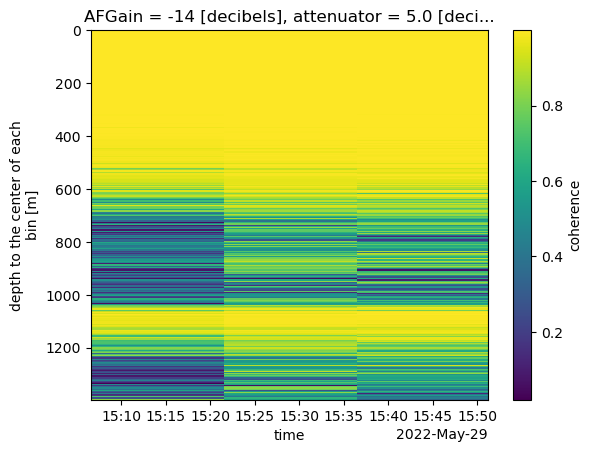

In [7]:
abs(c1.coherence.isel(attenuator_setting_pair=1)).plot(x='time', y='bin_depth', yincrease=False)

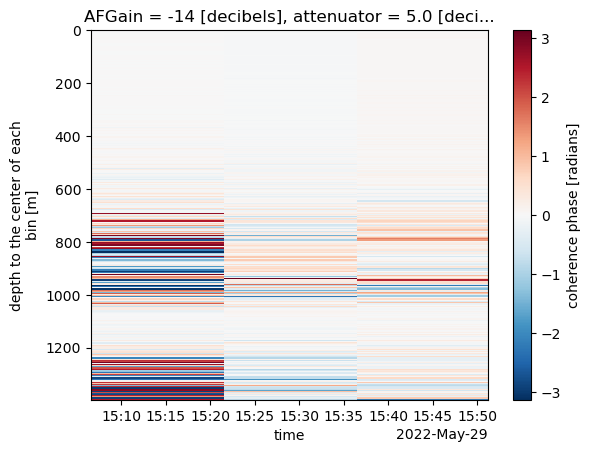

In [8]:
import xarray as xr
c1.phase.isel(attenuator_setting_pair=1).plot(x='time', y='bin_depth', yincrease=False)

## Compare this to the older way of doing the binned coherence calculation

The following defines the bins with a set window size 

In [9]:
import numpy as np
step = 20
idxs = np.arange(bin_size//2, b1.profile_stacked.shape[1]-bin_size//2, step).astype(int)
ds = b1.profile_range[idxs]

THe following defines a function to compute the coherence:

In [10]:
def coherence(s1, s2):
    """
    Phase correlation between two elements of the scattering matrix
    Jordan et al. (2019) eq. 13
    Parameters
    ---------
    s1: array
        first acquisition
    s2:
        second acquisition
    Output
    ---------
    c:  array
        phase coherence
    """
    #top = np.einsum('ij,ij->i', s1, np.conj(s2))
    top = (s1 * np.conj(s2)).sum(axis=1)
    bottom = np.sqrt(np.sum(np.abs(s1)**2,axis=1)*np.sum(np.abs(s2)**2,axis=1))
    c = top/bottom


    #top3 = (arr1 * arr2.conj()).sum(dim = 'profile_range')
    #bottom3 = np.sqrt(  (abs(arr1)**2).sum(dim = 'profile_range') * (abs(arr2)**2).sum(dim = 'profile_range')  )
    #co3 = (top3/bottom3).rename('coherence')
    #assert np.allclose(co3, c)
    return c

In [11]:
acq1 = b1.profile_stacked.isel(attenuator_setting_pair=1)
acq2 = b2.profile_stacked.isel(attenuator_setting_pair=1)
c2 = np.empty_like(np.stack([ds.data]*acq1.shape[0])).astype(np.cdouble)
for i, idx in enumerate(idxs):
# index two sub_arrays to compare
    arr1 = acq1[:,idx-bin_size//2:idx+bin_size//2]
    arr2 = acq2[:,idx-bin_size//2:idx+bin_size//2]
    # correlation coefficient between acquisitions
    # amplitude is coherence between acquisitions and phase is the offset
    c2[:,i] = coherence(arr1.data, arr2.data)


In [12]:
c2.shape

(3, 332)

Text(0.5, 1.0, 'Coherence Amplitude')

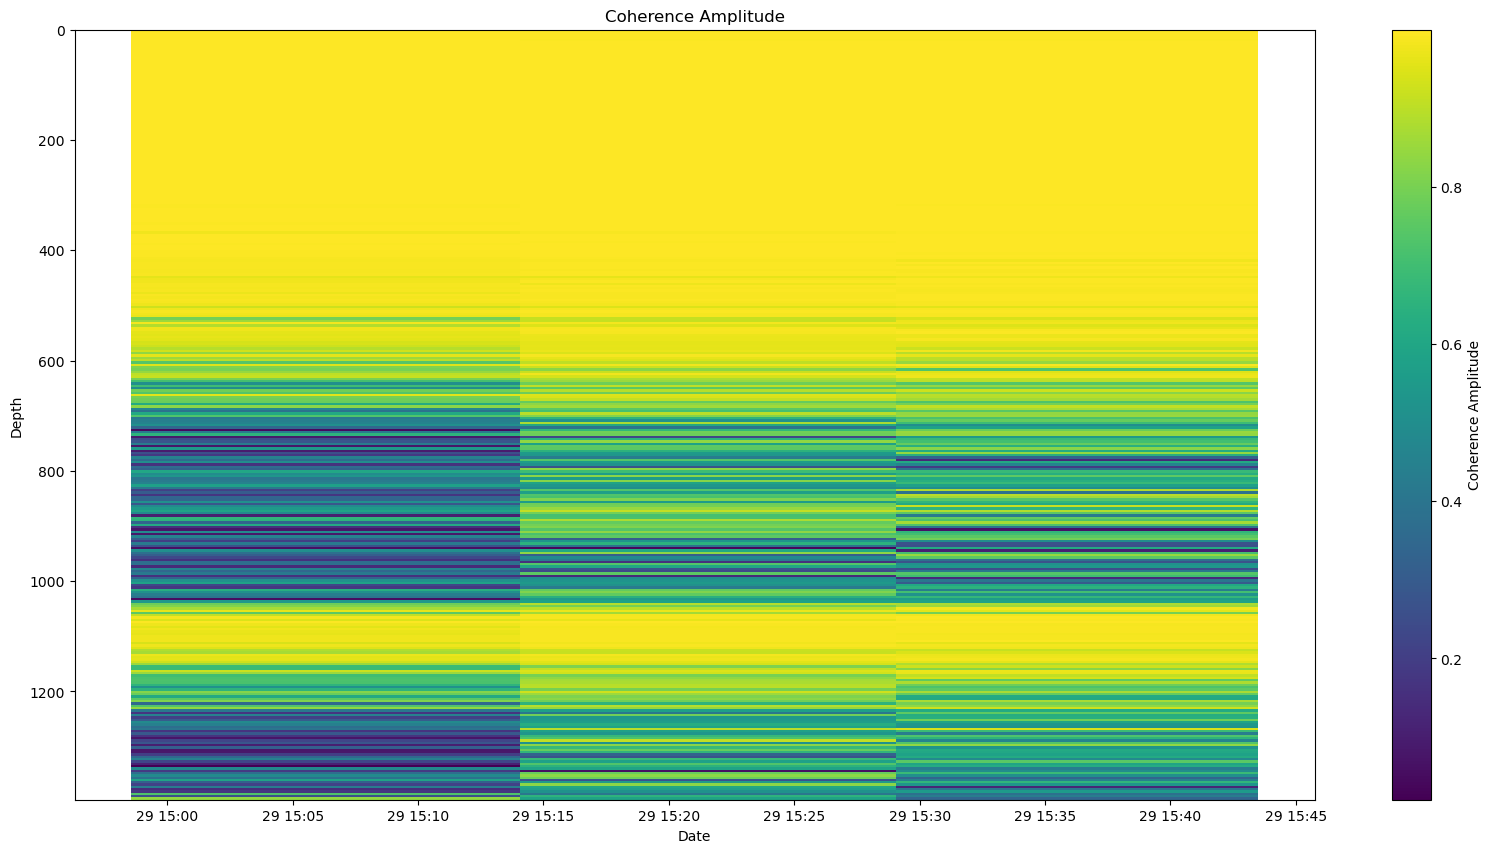

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))

im = plt.pcolormesh(t1,ds.values,abs(c2).transpose())
fig.colorbar(im,label='Coherence Amplitude')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Amplitude')

Text(0.5, 1.0, 'Coherence Phase')

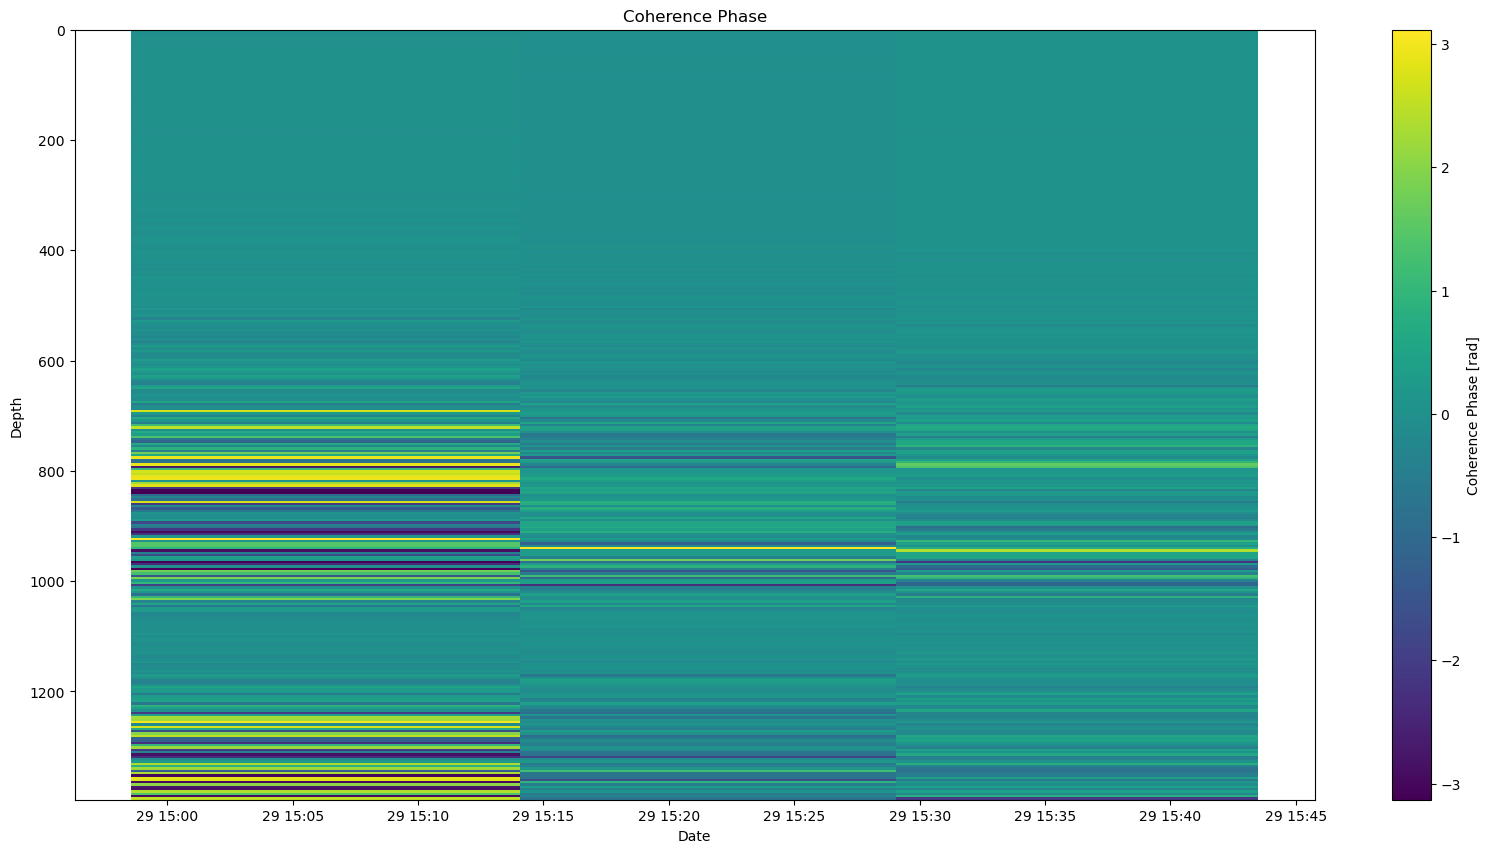

In [14]:
fig, ax = plt.subplots(figsize=(20,10))
phi = -np.angle(c2).astype(float)
im = plt.pcolormesh(t1,ds.values,phi.transpose())
fig.colorbar(im,label='Coherence Phase [rad]')
ax.invert_yaxis()
plt.ylabel('Depth')
plt.xlabel('Date')
plt.title('Coherence Phase')

## Compare the bin depth we get from the two methods

Take a look at the depth of the first bin:


In [15]:
ds.isel(profile_range=0)   # or equivelently ds[0]  or b1.profile_range[idxs[0]]

<xarray.DataArray 'profile_range' ()> Size: 8B
array(2.10289558)
Coordinates:
    profile_range  float64 8B 2.103
Attributes:
    long_name:  depth
    units:      meters

This is slightly different than the depth of th first bin in the xarray c, computed above with the newer method. Why? TLDR: because the value at index 10 is the midpoint of the values between 0 and 19, inclusive.

In [16]:
c1.bin_depth.isel(bin=0)  

<xarray.DataArray 'bin_depth' ()> Size: 8B
array(1.9977508)
Coordinates:
    bin_depth  float64 8B 1.998
Attributes:
    units:          m
    long_name:      depth to the center of each bin
    standard_name:  bin depth

Display the depths of the data points in the first bin in the older method:

In [17]:
b1.profile_range.isel(profile_range=slice(0,20)).data

array([0.        , 0.21028956, 0.42057912, 0.63086867, 0.84115823,
       1.05144779, 1.26173735, 1.4720269 , 1.68231646, 1.89260602,
       2.10289558, 2.31318514, 2.52347469, 2.73376425, 2.94405381,
       3.15434337, 3.36463292, 3.57492248, 3.78521204, 3.9955016 ])

Display the depths of the data points going in the first bin in the xarray `c`

In [18]:
bin_size = 20
b1_binned = b1.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))
b1_binned.profile_range.isel(bin=0)

<xarray.DataArray 'profile_range' (sample_in_bin: 20)> Size: 160B
array([0.        , 0.21028956, 0.42057912, 0.63086867, 0.84115823,
       1.05144779, 1.26173735, 1.4720269 , 1.68231646, 1.89260602,
       2.10289558, 2.31318514, 2.52347469, 2.73376425, 2.94405381,
       3.15434337, 3.36463292, 3.57492248, 3.78521204, 3.9955016 ])
Coordinates:
    profile_range  (sample_in_bin) float64 160B 0.0 0.2103 ... 3.785 3.996
Dimensions without coordinates: sample_in_bin
Attributes:
    long_name:  depth
    units:      meters

They are the same. 

The older method takes the 10th value as the bin depth, which is

In [19]:
b1.profile_range.isel(profile_range=10).data

array(2.10289558)

But this is different than the mean of the depths of the data points in the bin, which is what the newer method uses as the bin depth:

In [20]:
b1.profile_range.isel(profile_range=slice(0,20)).data.mean()

np.float64(1.9977507989529077)

The newer method bin depths are consistenly around 10cm shallower than the older method:

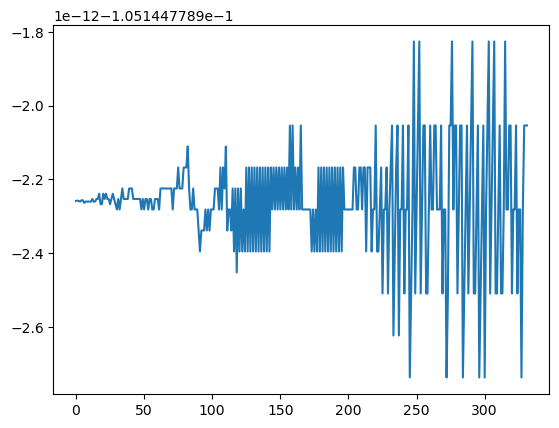

In [21]:
import matplotlib.pyplot as plt
plt.plot(c1.bin_depth.data - ds.data)

In [22]:
difference = ds.data - c1.bin_depth.data 
difference

array([0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514478,
       0.10514478, 0.10514478, 0.10514478, 0.10514478, 0.10514

This difference is 

$$
\frac{dz}{2N}
$$

where $dz$ is the vertical spacing of the data points and $N$ is the number of data points in each bin.

In [23]:
assert np.allclose((c1.bin_depth.data[1] - c1.bin_depth.data[0])/bin_size/2,  difference)

## Compare the coherence values we get from the two methods

They are all very close.

In [24]:
assert np.allclose(c1.coherence.isel(attenuator_setting_pair = 1, time = 0).data.real, c2[0,:].real)
assert np.allclose(c1.coherence.isel(attenuator_setting_pair = 1, time = 0).data.imag, c2[0,:].imag)

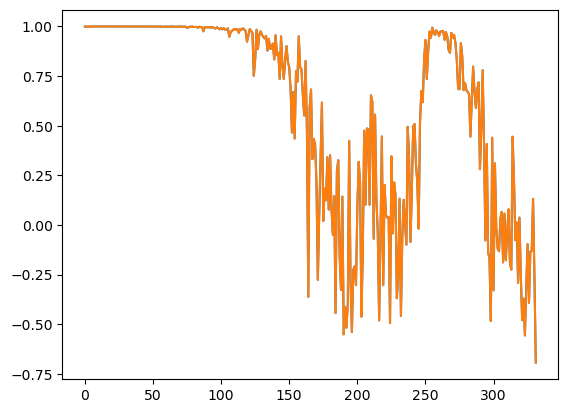

In [25]:
plt.plot(c2[0,:].real)
plt.plot(c1.coherence.isel(attenuator_setting_pair = 1, time = 0).data.real)

## Unwrap phase and compute displacement

In [26]:
# Phase wrapping
win_wrap = 4
thresh = 1 #0.97
phi = -np.angle(c2).astype(float)
for i in range(c2.shape[1]-1):
    for t in range(c2.shape[0]):
        idx = i+1
        if np.all(abs(c2[t,idx-win_wrap:idx+win_wrap]) < thresh):
            continue
        elif phi[t,idx]-phi[t,idx-1] > np.pi:
            phi[t,idx:] -= 2.*np.pi
        elif phi[t,idx]-phi[t,idx-1] < -np.pi:
            phi[t,idx:] += 2.*np.pi

The code above is from George. I doesnt do anything when the threshold `thresh` is set to 1 because the following is true:

In [27]:
assert np.all(abs(c2) < thresh)

In [28]:
phi == -np.angle(c2).astype(float)

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
      

The following is what the matlab code and George's code uses to compute the displacement:

In [29]:
def phase2range_old(phi, lambdac=0.5608, rc=None, K=2e8, ci=1.6823e8):
        """
        Convert phase difference to range for FMCW radar
        Parameters
        ---------
        lambdac: float
            wavelength (m) at center frequency
        rc: float; optional
            coarse range of bin center (m)
        K:  float; optional
            chirp gradient (rad/s/s)
        ci: float; optional
            propagation velocity (m/s)
        ### Original Matlab File Notes ###
        Craig Stewart
        2014/6/10
        """

        if not all([K,ci]) or rc is None:
            # First order method
            # Brennan et al. (2014) eq 15
            r = lambdac*phi/(4.*np.pi)
        else:
            # Precise
            r = phi/((4.*np.pi/lambdac) - (4.*rc[None,:]*K/ci**2.))

        return r


In [30]:
# a version that works with xarray versions
lambdac=0.5608
K=2e8
ci=1.6823e8
w1 = (c1.phase/((4.*np.pi/lambdac) - (4.*c1.bin_depth*K/ci**2.))).rename("displacement")
#w1.attrs["name"] = "displacement"
w1.attrs["units"] = "m"
w1.attrs["long_name"] = "displacement since previous measurement"

In [31]:
w1

<xarray.DataArray 'displacement' (time: 3, bin: 332, attenuator_setting_pair: 2)> Size: 16kB
array([[[ 1.07269385e-06,  2.61655274e-07],
        [-1.44880548e-03, -1.45404391e-03],
        [-1.46136966e-03, -1.46877727e-03],
        ...,
        [ 1.02972058e-01,  6.19598381e-02],
        [-1.16162880e-01, -1.31123716e-01],
        [ 1.33146961e-01,  1.13115487e-01]],

       [[-4.68415564e-06, -7.85856104e-07],
        [-9.90740484e-04, -9.85008411e-04],
        [-2.69188239e-03, -2.68596250e-03],
        ...,
        [ 4.94464023e-02, -2.45780506e-02],
        [-1.97323862e-02, -1.48405271e-02],
        [-1.38428233e-01, -3.38882318e-02]],

       [[ 1.15906280e-05,  1.38582378e-06],
        [-2.62426739e-04, -2.37395711e-04],
        [ 1.00509773e-03,  1.01175491e-03],
        ...,
        [-3.32374306e-02, -1.18852379e-02],
        [ 7.08774459e-02,  3.52051517e-02],
        [ 5.26746766e-03, -9.48934467e-02]]])
Coordinates:
    AFGain      (attenuator_setting_pair) int64 16B -4 -14
    attenuator  (attenuator_setting_pair) float64 16B 5.0 5.0
    filename    (time) <U83 996B 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
  * time        (time) datetime64[ns] 24B 2022-05-29T15:14:04.500000 ... 2022...
    bin_depth   (bin) float64 3kB 1.998 6.204 10.41 ... 1.39e+03 1.394e+03
Dimensions without coordinates: bin, attenuator_setting_pair
Attributes:
    units:      m
    long_name:  displacement since previous measurement

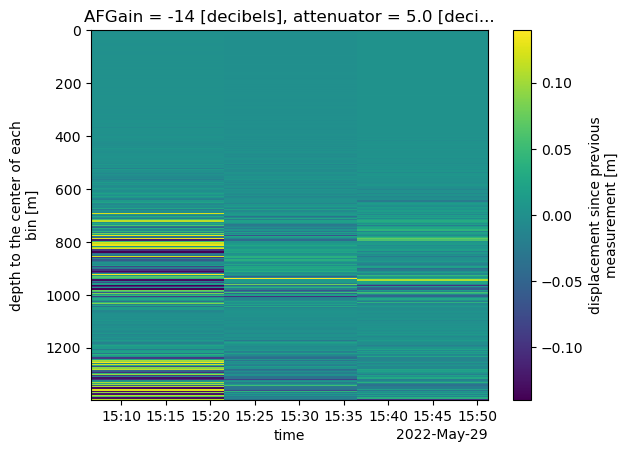

In [32]:
w1.isel(attenuator_setting_pair=1).plot(x='time', y='bin_depth', yincrease=False, cmap='viridis')

In [33]:
w2 = phase2range_old(phi)
w2

array([[ 2.61655274e-07, -1.45404390e-03, -1.46877725e-03,
        -1.78661294e-04, -2.50260172e-04, -5.02727730e-04,
         8.86270582e-05,  1.65768314e-04, -3.00787720e-04,
         3.31126749e-05,  2.79548690e-04,  1.65945760e-04,
        -6.26837265e-05, -8.07678389e-05,  4.37456453e-05,
         9.87706046e-05,  6.84070332e-05,  6.56447110e-05,
         3.13559604e-04, -2.69243166e-04, -1.38087055e-04,
        -5.78693696e-05,  1.72902229e-04,  1.73270359e-05,
         5.90788966e-05,  1.43544845e-04,  1.76478139e-04,
        -2.28782396e-06,  1.21652417e-04, -3.04858861e-05,
         1.31594584e-04, -4.24337108e-04, -1.86825543e-04,
         6.71856627e-05,  6.22102400e-05, -3.22395592e-04,
         1.84180293e-04,  4.07106257e-04,  1.53857168e-04,
         5.18399487e-04, -1.59004207e-04,  7.80691288e-05,
         1.37661078e-04, -8.79913468e-04,  2.60860275e-06,
         5.09796727e-04,  7.51963526e-04,  5.54886203e-04,
         2.65539489e-04,  5.69632471e-04,  4.10373540e-0

Text(0.5, 1.0, 'Range difference [m]')

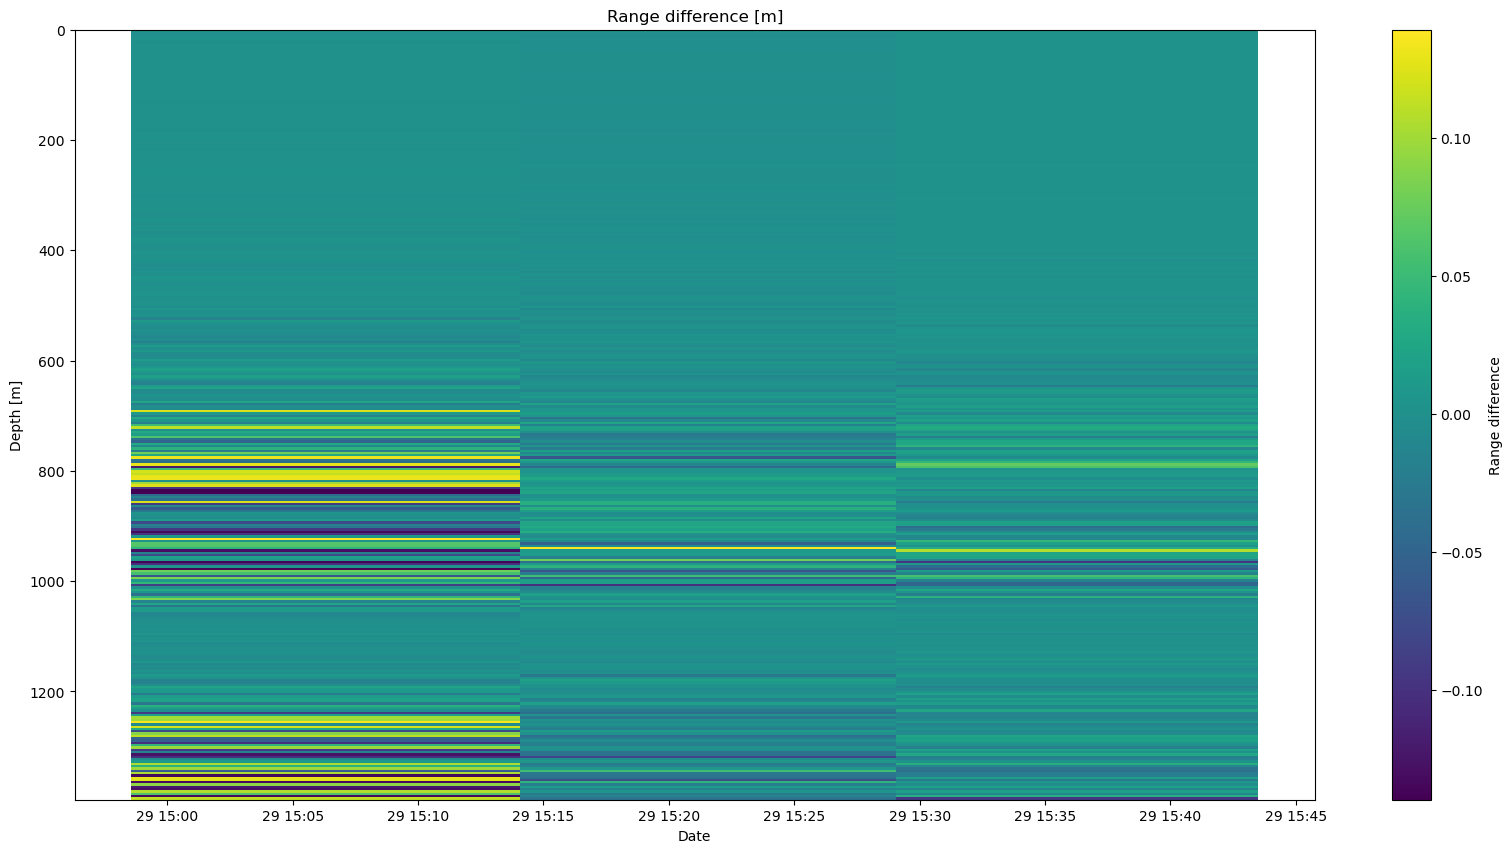

In [34]:
fig, ax = plt.subplots(figsize=(20,10))
im = plt.pcolormesh(t1,ds.values,w2.transpose())
fig.colorbar(im,label='Range difference')
ax.invert_yaxis()
plt.ylabel('Depth [m]')
plt.xlabel('Date')
plt.title('Range difference [m]')

In [35]:
assert np.allclose(w1.isel(attenuator_setting_pair=1).data, w2)

## Compare the size of the terms in the displacement calculation
The precise calculation takes account of both constant terms in eqn 13 of Brennan++ 2014:

$$
\phi_d(t) = \phi_t - \phi_r = \omega_c \tau + K \tau \left(t- \frac{T}{2}\right) - \frac{K \tau^2}{2}
$$

The constant terms are the first and third terms on the right. 

The two-way travel time is

$$
\tau = 2 R/c_i
$$

For a reflector 5000m away, thicker than any ice on earth:


In [36]:
tau = 2 * 5000  / 1.6823e8
print(f'tau = {tau} s')


tau = 5.944243000653867e-05 s


so the first and third terms are:

In [37]:
T = 1  # [s]
f_1 = 200e6  # [Hz]
f_2 = 400e6  # [Hz]
B = f_2 - f_1       # bandwidth
f_c = (f_1 + f_2) / 2  # center frequency
omega_c = 2*np.pi*f_c
K = B/T 

print(f"First term: {omega_c * tau}")
print(f"Second term: {K* tau**2 / 2}")

First term: 112046.34085204042
Second term: 0.3533402485082249


As a function of R the ratio of the two terms is

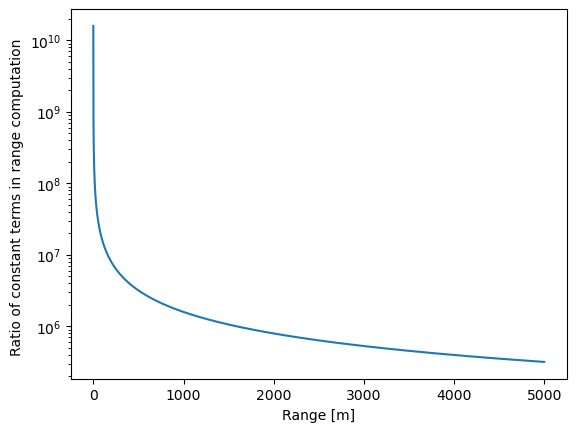

In [38]:
R = np.arange(0.1,5000)
tau = 2*R/1.6823e8
ratio  = (omega_c * tau) / (K* tau**2 / 2)
plt.plot(R, ratio)
plt.xlabel('Range [m]')
plt.ylabel('Ratio of constant terms in range computation ')
# vertical axis log
plt.yscale('log')


This justifies neglecting the third term. 

We assume then that the phase we measure is 

$$
\phi_d = \omega_c \tau
$$

substituting in the definition of \tau gives

$$
\phi_d = \omega_c 2 R /c_i
$$

The wavelength in ice at the center frequency is

$$
\lambda_c = \frac{c_i}{ f_c}
$$

where $f_c$ is the center frequency of the chirp in Hz:

$$
f_c = \frac{\omega_c}{2\pi}
$$

Combining these expressions gives

$$ 
\lambda_c = \frac{2\pi c_i}{ \omega_c}
$$

Then putting this into an expression above gives

$$
\phi_d = 4\pi R /\lambda_c
$$

and rearranging finally gives

$$
R = \frac{\lambda_c \phi_d}{4\pi}
$$

Or alternatively

$$
R = \frac{c_i \phi_d}{2 \omega_c}
$$

or 

$$
R = \frac{c_i \phi_d}{4 \pi f_c}
$$



In [39]:
def phase2range(phi, f_c = 300e6, ci=1.6823e8):
        """
        Convert phase difference to range for FMCW radar
        Parameters
        ---------
        lambdac: float
            wavelength (m) at center frequency
        rc: float; optional
            coarse range of bin center (m)
        K:  float; optional
            chirp gradient (rad/s/s)
        ci: float; optional
            propagation velocity (m/s)
        ### Original Matlab File Notes ###
        Craig Stewart
        2014/6/10
        """

        return ci*phi/(4*np.pi*f_c)

In [40]:
w = phase2range(phi)
w

array([[ 2.61639721e-07, -1.45395747e-03, -1.46868995e-03,
        -1.78650674e-04, -2.50245297e-04, -5.02697849e-04,
         8.86217903e-05,  1.65758461e-04, -3.00769842e-04,
         3.31107067e-05,  2.79532074e-04,  1.65935896e-04,
        -6.26800007e-05, -8.07630382e-05,  4.37430451e-05,
         9.87647338e-05,  6.84029672e-05,  6.56408091e-05,
         3.13540967e-04, -2.69227162e-04, -1.38078848e-04,
        -5.78659299e-05,  1.72891952e-04,  1.73260060e-05,
         5.90753850e-05,  1.43536313e-04,  1.76467649e-04,
        -2.28768798e-06,  1.21645186e-04, -3.04840741e-05,
         1.31586762e-04, -4.24311886e-04, -1.86814438e-04,
         6.71816693e-05,  6.22065423e-05, -3.22376429e-04,
         1.84169346e-04,  4.07082059e-04,  1.53848023e-04,
         5.18368674e-04, -1.58994756e-04,  7.80644884e-05,
         1.37652896e-04, -8.79861167e-04,  2.60844770e-06,
         5.09766425e-04,  7.51918830e-04,  5.54853222e-04,
         2.65523705e-04,  5.69598613e-04,  4.10349148e-0

In [41]:
phase2range(phi) - phase2range_old(phi)

array([[-1.55525008e-11,  8.64267652e-08,  8.73024993e-08,
         1.06194302e-08,  1.48751885e-08,  2.98815817e-08,
        -5.26789457e-09, -9.85308573e-09,  1.78784903e-08,
        -1.96818087e-09, -1.66160657e-08, -9.86363290e-09,
         3.72585155e-09,  4.80075124e-09, -2.60019290e-09,
        -5.87081577e-09, -4.06603859e-09, -3.90184920e-09,
        -1.86376370e-08,  1.60035167e-08,  8.20774224e-09,
         3.43969149e-09, -1.02771177e-08, -1.02989990e-09,
        -3.51158444e-09, -8.53214724e-09, -1.04896659e-08,
         1.35985733e-10, -7.23088544e-09,  1.81204744e-09,
        -7.82183688e-09,  2.52221296e-08,  1.11047042e-08,
        -3.99344167e-09, -3.69770803e-09,  1.91628383e-08,
        -1.09474734e-08, -2.41979468e-08, -9.14510034e-09,
        -3.08130936e-08,  9.45103468e-09, -4.64034289e-09,
        -8.18242263e-09,  5.23010858e-08, -1.55052470e-10,
        -3.03017550e-08, -4.46958824e-08, -3.29818238e-08,
        -1.57833743e-08, -3.38583257e-08, -2.43921505e-0

(array([102.,  99.,  99.,  99.,  99.,  99.,  99.,  99.,  99., 102.]),
 array([2.52012763e-09, 1.78133547e-07, 3.53746967e-07, 5.29360387e-07,
        7.04973807e-07, 8.80587227e-07, 1.05620065e-06, 1.23181407e-06,
        1.40742749e-06, 1.58304091e-06, 1.75865433e-06]),
 <BarContainer object of 10 artists>)

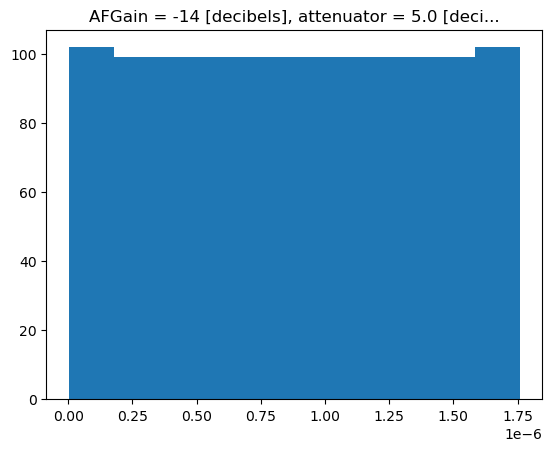

In [42]:
diff =  (c1.phase/((4.*np.pi/lambdac) - (4.*c1.bin_depth*K/ci**2.))   -  c1.phase/((4.*np.pi/lambdac)))/ (c1.phase/((4.*np.pi/lambdac))).rename('% percent difference')
diff.isel(attenuator_setting_pair=1).plot.hist()

## Uncertainty in the displacement calculation

In [43]:
sigma2 = (1./abs(c2))*np.sqrt((1.-abs(c2)**2.)/(2.*bin_size))
# convert the phase offset to a distance vector
w_err2 = phase2range_old(sigma2)
w_err2

array([[3.69718686e-06, 2.50050926e-04, 1.56562515e-04, 1.11244277e-04,
        3.17368157e-04, 1.72272524e-04, 7.02832276e-05, 9.65783261e-05,
        6.72416605e-05, 9.56071894e-05, 8.63636053e-05, 1.08449667e-04,
        4.14331143e-05, 6.38891925e-05, 8.70281621e-05, 6.11455888e-05,
        3.74204340e-05, 3.30329111e-05, 5.52627771e-05, 1.04180050e-04,
        1.00737289e-04, 6.25586712e-05, 1.06766832e-04, 8.03949343e-05,
        5.78356519e-05, 6.20771557e-05, 9.94461881e-05, 1.05636088e-04,
        5.01078650e-05, 7.17361348e-05, 8.94796805e-05, 1.14692049e-04,
        8.16200249e-05, 5.87041031e-05, 9.01188727e-05, 6.25027719e-05,
        9.85581507e-05, 1.75421839e-04, 8.74704749e-05, 1.34588532e-04,
        9.44155173e-05, 1.08850878e-04, 9.80169953e-05, 1.57755744e-04,
        1.12114460e-04, 1.52308817e-04, 1.94311281e-04, 1.71568209e-04,
        1.25799715e-04, 1.63961054e-04, 1.69471689e-04, 2.84500152e-04,
        1.16862044e-04, 3.18707053e-04, 1.82197927e-04, 2.011882

In [44]:
phase_uncertainty = (1./abs(c1.coherence))*np.sqrt((1.-abs(c1.coherence)**2.)/(2.*bin_size)).rename('phase_uncertainty')
disp_uncertainty = phase2range_old(phase_uncertainty).rename('disp_uncertainty')
assert np.allclose(disp_uncertainty.isel(attenuator_setting_pair=1).data, w_err2)


In [45]:
out = xr.merge([c1.coherence, c1.phase, disp_uncertainty, w1])
out

<xarray.Dataset> Size: 83kB
Dimensions:           (attenuator_setting_pair: 2, time: 3, bin: 332)
Coordinates:
    AFGain            (attenuator_setting_pair) int64 16B -4 -14
    attenuator        (attenuator_setting_pair) float64 16B 5.0 5.0
    filename          (time) <U83 996B 'ldeo-glaciology/GL_apres_2022/A101/Ca...
  * time              (time) datetime64[ns] 24B 2022-05-29T15:14:04.500000 .....
    bin_depth         (bin) float64 3kB 1.998 6.204 10.41 ... 1.39e+03 1.394e+03
Dimensions without coordinates: attenuator_setting_pair, bin
Data variables:
    coherence         (time, bin, attenuator_setting_pair) complex128 32kB (0...
    phase             (time, bin, attenuator_setting_pair) float64 16kB 2.404...
    disp_uncertainty  (time, bin, attenuator_setting_pair) float64 16kB 1.157...
    displacement      (time, bin, attenuator_setting_pair) float64 16kB 1.073...

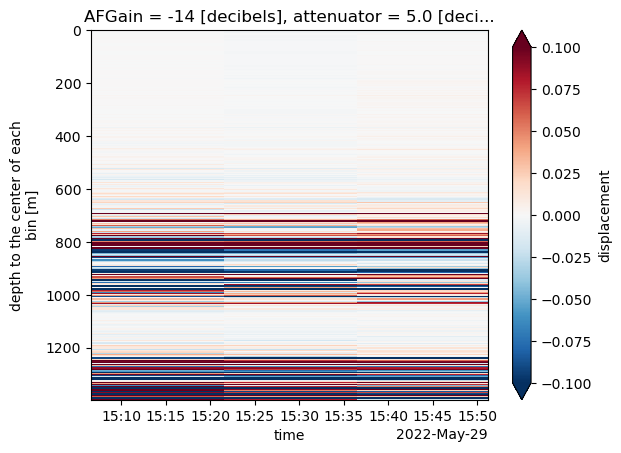

In [46]:
out.displacement.isel(attenuator_setting_pair=1).cumsum(dim='time').plot(x='time', y='bin_depth', yincrease=False,cmap='RdBu_r', vmin=-0.1, vmax=0.1)

In [47]:
coords = {'time':(['time'],t2,{'units': 'seconds','long_name':'Time of second burst'}),'profile_range':(['profile_range'],ds.profile_range.data,{'units': 'm','long_name':'Depth'})}
data_vars = {'time_diff':(['time'],np.cumsum(dt),{'units': 'seconds','long_name':'Time since first burst'}),
             'range_diff':(['time','profile_range'], w2, #np.cumsum(w,axis=0), 
                 {'units': 'm', 
                  'long_name':'Range difference'}),
    'err':(['time','profile_range'], w_err2, 
                 {'units': 'm', 
                  'long_name':'Error'})}
ds_xr = xr.Dataset(data_vars=data_vars, coords=coords)
ds_xr

<xarray.Dataset> Size: 19kB
Dimensions:        (time: 3, profile_range: 332)
Coordinates:
  * time           (time) datetime64[ns] 24B 2022-05-29T15:21:50 ... 2022-05-...
  * profile_range  (profile_range) float64 3kB 2.103 6.309 ... 1.394e+03
Data variables:
    time_diff      (time) timedelta64[ns] 24B 00:15:31 00:29:58 00:45:00
    range_diff     (time, profile_range) float64 8kB 2.617e-07 ... -0.09489
    err            (time, profile_range) float64 8kB 3.697e-06 ... 0.01989

In [48]:
assert np.allclose(ds_xr.range_diff.data, out.displacement.isel(attenuator_setting_pair=1).data)
assert np.allclose(ds_xr.err.data, out.disp_uncertainty.isel(attenuator_setting_pair=1).data)

In [49]:
def convert_to_seconds(s):
    seconds_per_unit = {"S": 1, "M": 60, "H": 3600, "D": 86400, "W": 604800}
    return int(s[:-1]) * seconds_per_unit[s[-1]]

def sum_error(errs):
    return np.sqrt(np.sum(errs**2))

def error_prop(data):
    return xr.apply_ufunc(sum_error, data, input_core_dims=[["time"]], vectorize = True)


In [50]:
disp_stack = ds_xr.range_diff.resample(time='2D').sum(dim='time')/convert_to_seconds('2D')*31536000
err_stack = ds_xr.err.resample(time='2D').apply(error_prop)/convert_to_seconds('2D')*31536000

## Implement the whole work flow in a function 
This works fine for computing the displacement, etc. The version currently implemented in the package is arranged slightly differently, but does the same thing. 

see below for the version in the package.


In [51]:
def disp(self, stride=1, bin_size=20):
    """Calculate the displacement between two time series of profiles in vertical bins."""
    
    # extract two time series
    b1_unaligned = self.isel(time=slice(0,-stride))
    b2_unaligned= self.isel(time=slice(stride,None))

    # change the time values to be the midpoints of the consequtive profiles
    t1 = b1_unaligned.time.data
    t2 = b2_unaligned.time.data
    dt = t2-t1
    b1 = b1_unaligned
    b2 = b2_unaligned
    b1['time'] = b1_unaligned.time+dt/2
    b2['time'] = b2_unaligned.time-dt/2
    dt_years_xr = xr.DataArray(dt.astype(float)/1e9/60/60/24/365, dims='time', coords={'time':b2.time})

    def binned_coherence(b1, b2, bin_size):
        """Calculate the coherence between two time series of profiles in vertical bins. 
        b1 and b2 are xarray DataArrays with dimensions "time" and "profile_range" (and, optionally, others)
        bin_size is the number of samples to include in each bin
        """

        # put the time series into vertical bins
        b1_binned = b1.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))
        b2_binned = b2.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))

        # compute the bin depth and add this to the timeseries
        bin_depth = b1_binned.profile_range.mean(dim='sample_in_bin').data
        b1_binned = b1_binned.assign_coords(bin_depth=("bin", bin_depth))
        b2_binned = b2_binned.assign_coords(bin_depth=("bin", bin_depth))

        # compute the coherence
        top = (b1_binned * np.conj(b2_binned)).sum(dim="sample_in_bin")
        bottom = np.sqrt( (np.abs(b1_binned)**2).sum(dim="sample_in_bin") * (np.abs(b2_binned)**2).sum(dim="sample_in_bin"))
        coherence = (top/bottom).rename("coherence")

        # add attributes related to the bin_depth
        coherence.bin_depth.attrs["units"] = "m"
        coherence.bin_depth.attrs["long_name"] = "depth to the center of each bin"
        coherence.bin_depth.attrs["standard_name"] = "bin depth"         

        # add attributes related to the coherence
        coherence.attrs["units"] = "unitless"
        coherence.attrs["long_name"] = "complex coherence between consequitive measurements"

        # return the coherence and the phase merged into an xarray dataset
        return coherence

    # compute the binned coherence
    coherence = binned_coherence(b1.profile_stacked,b2.profile_stacked, bin_size = bin_size)

    # compute the phase and add attributes
    phase = -xr.apply_ufunc(np.angle, coherence).rename("phase")
    phase.attrs["units"] = "radians"
    phase.attrs["long_name"] = "coherence phase"
    
    # compute displacement
    lambdac=0.5608    # wavelength in at the center frequency    [m]
    K=2e8             # rate of change of frequency with time during chirps [Hz/s]
    ci=1.6823e8       # speed of light in ice [m/s]
    phase2range = lambda phi, R: (phase/((4.*np.pi/lambdac) - (4.*R*K/ci**2.)))
    displacement = phase2range(phase,coherence.bin_depth).rename("displacement")
    displacement.attrs["units"] = "m"
    displacement.attrs["long_name"] = "displacement since previous measurement"


    # compute uncertainties
    phase_uncertainty = (1./abs(coherence))*np.sqrt((1.-abs(coherence)**2.)/(2.*bin_size)).rename('phase_uncertainty')
    disp_uncertainty = phase2range(phase_uncertainty, coherence.bin_depth).rename('disp_uncertainty')
    disp_uncertainty.attrs["units"] = "m"
    disp_uncertainty.attrs["long_name"] = "uncertainty in displacement since previous measurement"


    out = xr.merge([coherence, phase, disp_uncertainty, w1])

    return out

xr.Dataset.disp = disp

d = from_zarr.disp()



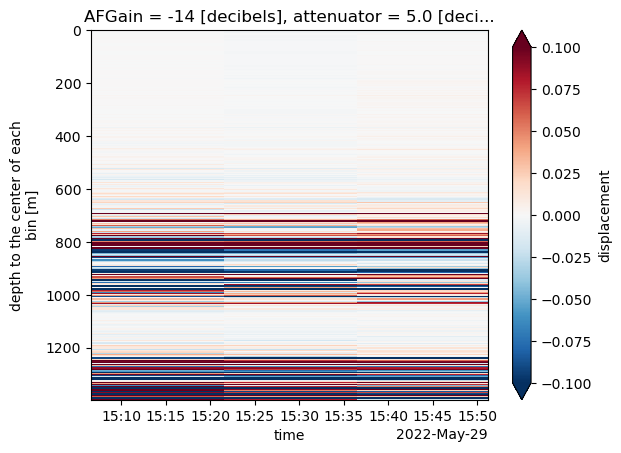

In [52]:
d.displacement.isel(attenuator_setting_pair=1).cumsum(dim='time').plot(x='time', y='bin_depth', yincrease=False,cmap='RdBu_r', vmin=-0.1, vmax=0.1)

In [53]:
assert np.allclose(d.displacement.isel(attenuator_setting_pair=1).data, w2)

## The version implemented in the XApRES package

In [35]:
from_zarr = xa.load.load_zarr().isel(time=slice(300,304), chirp_num=slice(0,1),attenuator_setting_pair=1)
def displacement_timeseries(da: xr.DataArray, 
                            offset: int=1,  
                            bin_size: int=20): 
    """
    Compute displacement, phase, coherence and associated uncertainties, as a function of depth adn time, given a time series of complex ApRES profiles. 

    Profiles a set offset apart are compared to compute the time series of displacement. 
    
    The time interval between outted profiles is offset*dt where dt is the time between measurements. 

    The profiles of displacement etc. are binned in depth, with bin_size samples in each bin.

    Parameters:
    - da (xr.DataArray): The input data array containing a time series of complex profiles.
    - offset (int, optional): The time offset between the two time series. Default is 1.
    - bin_size (int, optional): Size of the vertical bins. Default is 20.

    Returns:
    xr.Dataset: Timeseries of profiles of coherence, phase, displacement, and associated uncertainties, binned in depth.

    """
    # extract two time series
    profile1_unaligned = da.isel(time=slice(0,-offset))
    profile2_unaligned= da.isel(time=slice(offset,None))
    
    # compute the binned coherence, phase, and displacement, with uncertainties and put them into an xarray dataset  
    ds = compute_displacement(profile1_unaligned, profile2_unaligned, bin_size = bin_size)

    # add attributes related to the this processing
    ds.attrs["offset"] = offset
    ds.attrs["processing"] = f"Created by the displacement_timeseries function in xapres using an offset of {offset} and bin size of {bin_size} on {datetime.datetime.now() }"

    return ds

def compute_displacement(profile1_unaligned: xr.DataArray, 
                        profile2_unaligned: xr.DataArray, 
                        bin_size: int=20):
    """
    Compute displacement, coherence, and related uncertainties for binned time series data.

    Parameters:
    - profile1_unaligned (xr.DataArray): Unaligned time series data for the first measurement.
    - profile2_unaligned (xr.DataArray): Unaligned time series data for the second measurement.
    - bin_size (int, optional): Size of the vertical bins. Default is 20.

    Returns:
    xr.Dataset: Timeseries of profiles of coherence, phase, displacement, and associated uncertainties, binned in depth.

    """

    profiles = combine_profiles(profile1_unaligned, profile2_unaligned)

    profiles_binned = bin_profiles(profiles, bin_size)

    coherence = compute_coherence(profiles_binned.isel(shot_number=0), profiles_binned.isel(shot_number=1))
   
    # add attributes related to the bin_depth
    coherence.bin_depth.attrs["units"] = "m"
    coherence.bin_depth.attrs["long_name"] = "depth to the center of each bin"
    coherence.bin_depth.attrs["standard_name"] = "bin depth"         

    # add attributes related to the coherence
    coherence.attrs["units"] = "unitless"
    coherence.attrs["long_name"] = "complex coherence between measurements"

    # compute the phase and add attributes
    phase = -xr.apply_ufunc(np.angle, coherence, dask="allowed").rename("phase")
    phase.attrs["units"] = "radians"
    phase.attrs["long_name"] = "coherence phase"

    # compute phase uncertainties
    phase_uncertainty = ((1./abs(coherence))*np.sqrt((1.-abs(coherence)**2.)/(2.*bin_size))).rename('phase_uncertainty')
    phase_uncertainty.attrs["units"] = "radians"
    phase_uncertainty.attrs["long_name"] = "uncertainty in coherence phase"

    # compute the displacement
    displacement = phase2range(phase).rename("displacement")
    displacement.attrs["units"] = "m"
    displacement.attrs["long_name"] = "displacement since previous measurement"

    # compute the displacement uncertainty
    disp_uncertainty = phase2range(phase_uncertainty).rename('disp_uncertainty')
    disp_uncertainty.attrs["units"] = "m"
    disp_uncertainty.attrs["long_name"] = "uncertainty in displacement since previous measurement"

    # compbine to an xarray dataset
    da_list = [profiles, coherence, phase, phase_uncertainty, displacement, disp_uncertainty]
    ds = xr.merge(da_list)

    # add attributes related to this processing
    ds.attrs["bin_size"] = bin_size
    ds.attrs["description"] = "Time series of profiles of coherence, phase, displacement, and associated uncertainties, binned in depth."
    ds.attrs["processing"] = f"Created by the compute_displacement function in xapres using a bin size of {bin_size} on {datetime.datetime.now() }"

    return ds

def combine_profiles(profile1_unaligned, profile2_unaligned):
    """ Align two timeseries of profiles, while recording their midpoint time and the time of each profile"""

    if 'time' not in profile1_unaligned.dims and 'time' in profile1_unaligned.coords:
        # data is taken in attended mode and we dont need to get the midpoint time and align
        print('attended mode')
        profiles = xr.concat([profile1_unaligned, profile2_unaligned], dim='shot_number')
        

    else:

        # in the case when we selected the time step with .isel(time=N), where N is an integer, we dont have time as a dimension. THe following accounts for this scenario
        if 'time' not in profile1_unaligned.dims:
            profile1_unaligned = profile1_unaligned.expand_dims(dim="time")
        if 'time' not in profile2_unaligned.dims:
            profile2_unaligned = profile2_unaligned.expand_dims(dim="time")

        # record the time interval between measurements
        t1 = profile1_unaligned.time.data
        t2 = profile2_unaligned.time.data
        dt = t2-t1

        # change the name of the time coordinates so that they can be retained when the profiles are concatenated, then drop the original 'time' coordinates (the latter is achieved with drop_vars)
        profile1_unaligned = profile1_unaligned.assign_coords(profile_time=("time", profile1_unaligned.time.data)).drop_vars("time")
        profile2_unaligned = profile2_unaligned.assign_coords(profile_time=("time", profile2_unaligned.time.data)).drop_vars("time")

        # concatenate the two profiles
        profiles = xr.concat([profile1_unaligned, profile2_unaligned], dim='shot_number', coords=['profile_time', 'burst_number', 'filename'])

        # add the midpoint time 
        profiles = profiles.assign_coords(time=("time", t1+dt/2))

    return profiles

def bin_profiles(profiles, bin_size):
    """Put the time series into vertical bins"""
    
    # Bin in depth
    profiles_binned = profiles.coarsen(profile_range=bin_size, boundary='trim').construct(profile_range=("bin", "sample_in_bin"))

    # Compute the bin depth and add it to the DataArray
    bin_depth = profiles_binned.profile_range.mean(dim='sample_in_bin').data
    profiles_binned = profiles_binned.assign_coords(bin_depth=("bin", bin_depth))

    return profiles_binned

def compute_coherence(b1_binned, b2_binned):
    # compute the coherence
    top = (b1_binned * np.conj(b2_binned)).sum(dim="sample_in_bin")
    bottom = np.sqrt( (np.abs(b1_binned)**2).sum(dim="sample_in_bin") * (np.abs(b2_binned)**2).sum(dim="sample_in_bin"))
    coherence = (top/bottom).rename("coherence")

    return (top/bottom).rename("coherence")

def phase2range(phi, 
                lambdac=0.5608, 
                rc=None, 
                K=2e8, 
                ci=1.6823e8):
        """
        Convert phase difference to range for FMCW radar
        Parameters
        ---------
        lambdac: float
            wavelength (m) at center frequency
        rc: float; optional
            coarse range of bin center (m)
        K:  float; optional
            chirp gradient (rad/s/s)
        ci: float; optional
            propagation velocity (m/s)
        ### Original Matlab File Notes ###
        Craig Stewart
        2014/6/10
        """

        if not all([K,ci]) or rc is None:
            # First order method
            # Brennan et al. (2014) eq 15
            r = lambdac*phi/(4.*np.pi)
        else:
            # Precise
            # Appears to be from Stewart (2018) eqn 4.8, with tau = 2*R/ci and omega_c = 2 pi /lambdac, where R is the range
            r = phi/((4.*np.pi/lambdac) - (4.*rc[None,:]*K/ci**2.))
        return r

xr.DataArray.displacement_timeseries_NB = displacement_timeseries

d = from_zarr.profile_stacked.displacement_timeseries_NB()
#d.displacement.isel(attenuator_setting_pair=1).cumsum(dim='time').plot(x='time', y='bin_depth', yincrease=False,cmap='RdBu_r', vmin=-0.1, vmax=0.1)
d

<xarray.Dataset> Size: 745kB
Dimensions:            (shot_number: 2, time: 3, profile_range: 6658, bin: 332)
Coordinates:
    AFGain             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    attenuator         float64 8B dask.array<chunksize=(), meta=np.ndarray>
    burst_number       (shot_number, time) int64 48B dask.array<chunksize=(1, 1), meta=np.ndarray>
    filename           (shot_number, time) <U83 2kB 'ldeo-glaciology/GL_apres...
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    profile_time       (shot_number, time) datetime64[ns] 48B 2022-05-29T15:0...
  * time               (time) datetime64[ns] 24B 2022-05-29T15:14:04.500000 ....
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: shot_number, bin
Data variables:
    profile_stacked    (shot_number, time, profile_range) complex128 639kB dask.array<chunksize=(1, 3, 6658), meta=np.ndarray>
    coherence          (time, bin) complex128 16kB dask.array<chunksize=(3, 332), meta=np.ndarray>
    phase              (time, bin) float64 8kB dask.array<chunksize=(3, 332), meta=np.ndarray>
    phase_uncertainty  (time, bin) float64 8kB dask.array<chunksize=(3, 332), meta=np.ndarray>
    displacement       (time, bin) float64 8kB dask.array<chunksize=(3, 332), meta=np.ndarray>
    disp_uncertainty   (time, bin) float64 8kB dask.array<chunksize=(3, 332), meta=np.ndarray>
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       1

This gives the same as George's notes (saved as strain_rate_steps_new.ipynb).

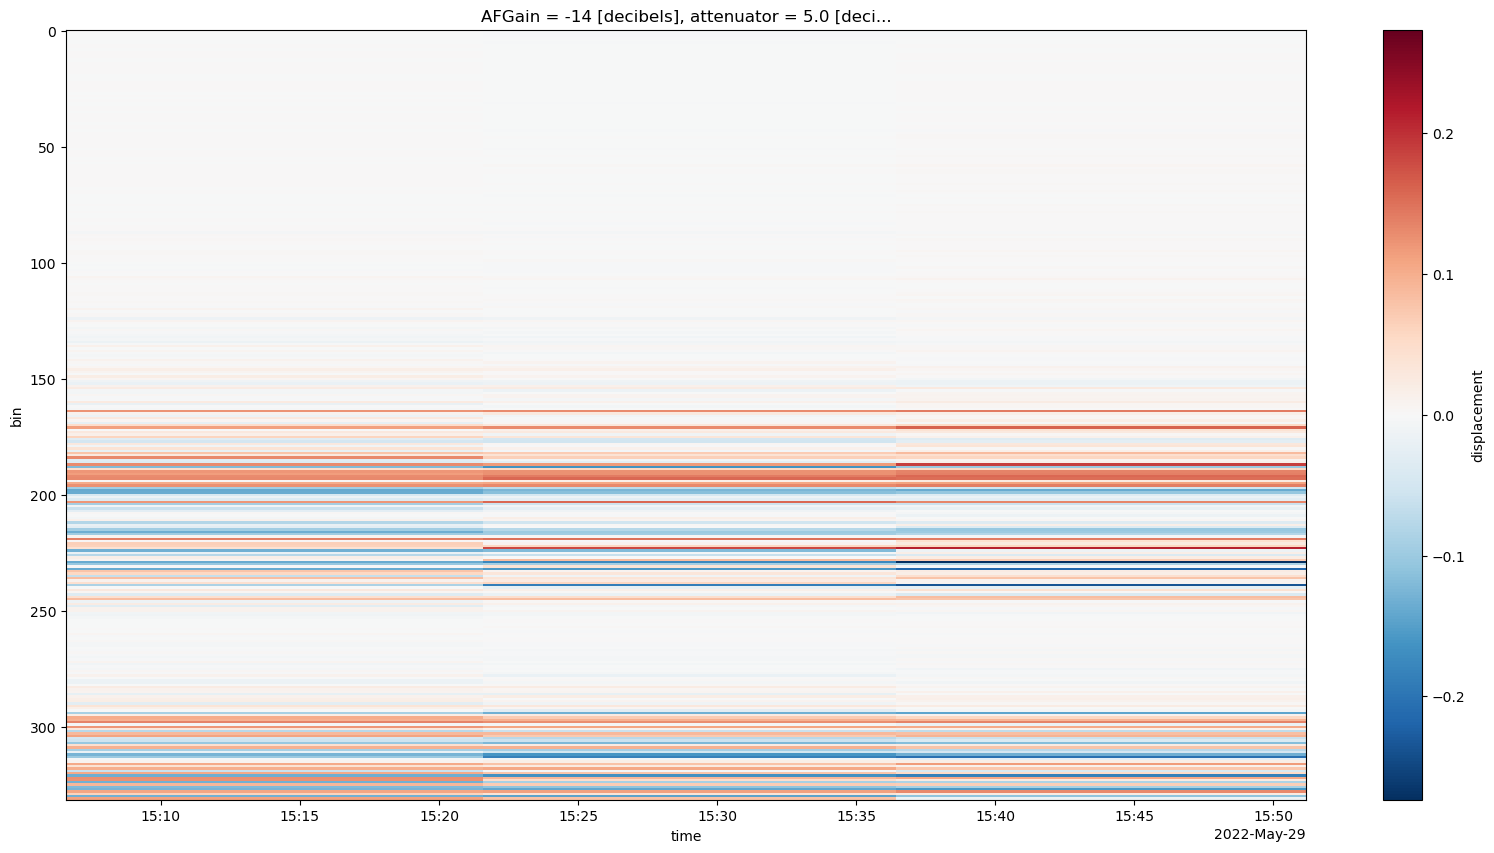

In [3]:
d.displacement.cumsum(dim='time').plot(x='time', cmap='RdBu_r', figsize=(20,10), yincrease=False)

## Test the implementation in utils.py and load.py

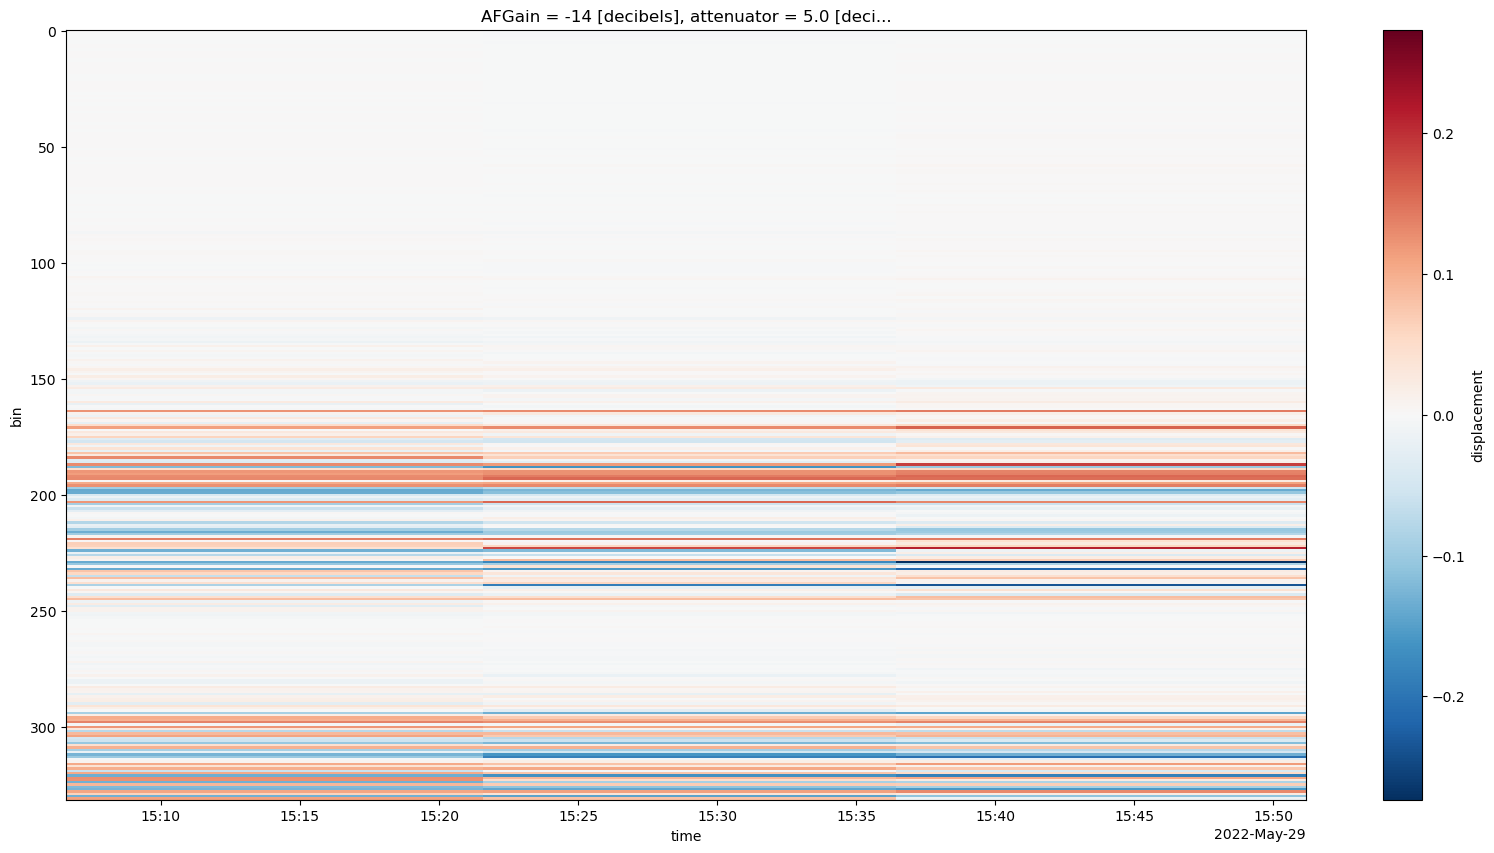

In [4]:
from_zarr.profile_stacked.displacement_timeseries().displacement.cumsum(dim='time').plot(x='time', cmap='RdBu_r', figsize=(20,10), yincrease=False)
# (note that .displacement_timeseries() is the version that is implemented in utils.py and .displacement_timeseries_NB() is the version that is implemented in this notebook)

Now test without just selecting one attenuator pair

In [24]:
from_zarr2 = xa.load.load_zarr().isel(time=slice(300,304))
from_zarr2

<xarray.Dataset> Size: 69MB
Dimensions:          (attenuator_setting_pair: 2, time: 4, chirp_time: 40001,
                      chirp_num: 20, profile_range: 6658)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number     (time) int64 32B dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 160B 0 1 2 3 4 5 6 ... 14 15 16 17 18 19
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U83 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * profile_range    (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03 1.4e+03
  * time             (time) datetime64[ns] 32B 2022-05-29T15:06:19 ... 2022-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 51MB dask.array<chunksize=(4, 40001, 20, 2), meta=np.ndarray>
    latitude         (time) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    longitude        (time) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 17MB dask.array<chunksize=(4, 6658, 20, 2), meta=np.ndarray>
    profile_stacked  (time, profile_range, attenuator_setting_pair) complex128 852kB dask.array<chunksize=(4, 6658, 2), meta=np.ndarray>
    temperature_1    (time) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>
    temperature_2    (time) float64 32B dask.array<chunksize=(4,), meta=np.ndarray>

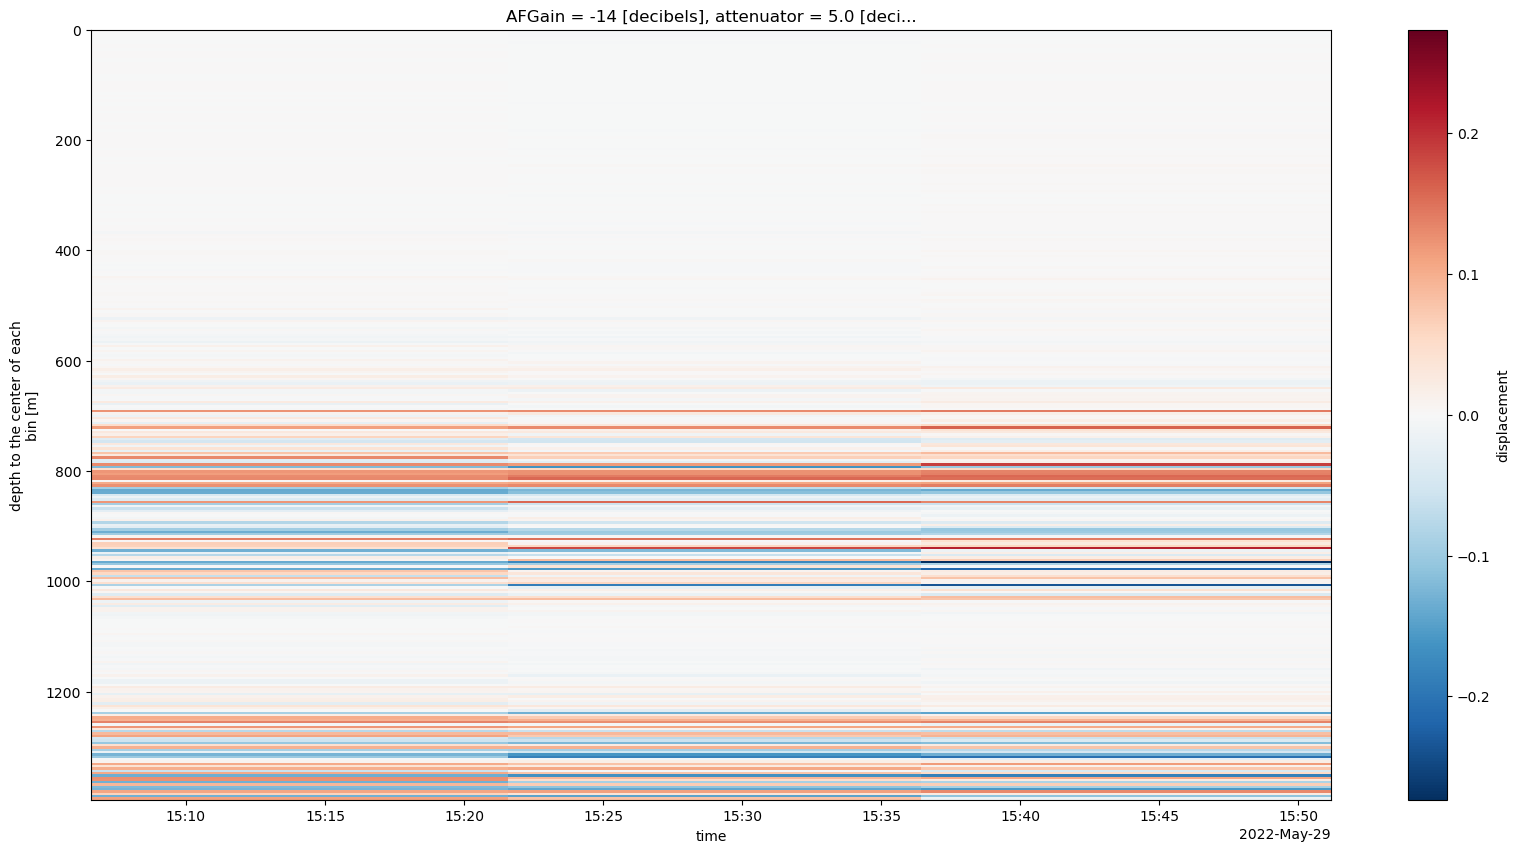

In [6]:
from_zarr2.profile_stacked.displacement_timeseries().displacement.isel(attenuator_setting_pair=1).cumsum(dim='time').plot(x='time', y='bin_depth', cmap='RdBu_r', figsize=(20,10), yincrease=False)

In [22]:
from_zarr2.profile_stacked.displacement_timeseries()#.displacement.isel(attenuator_setting_pair=0).cumsum(dim='time').plot(x='time', y='bin_depth', cmap='RdBu_r', figsize=(20,10), yincrease=False)

<xarray.Dataset> Size: 1MB
Dimensions:            (attenuator_setting_pair: 2, shot_number: 2, time: 3,
                        profile_range: 6658, bin: 332)
Coordinates:
    AFGain             (attenuator_setting_pair) int64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    attenuator         (attenuator_setting_pair) float64 16B dask.array<chunksize=(2,), meta=np.ndarray>
    burst_number       (shot_number, time) int64 48B dask.array<chunksize=(1, 1), meta=np.ndarray>
    filename           (shot_number, time) <U83 2kB 'ldeo-glaciology/GL_apres...
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    profile_time       (shot_number, time) datetime64[ns] 48B 2022-05-29T15:0...
  * time               (time) datetime64[ns] 24B 2022-05-29T15:14:04.500000 ....
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: attenuator_setting_pair, shot_number, bin
Data variables:
    profile_stacked    (shot_number, time, profile_range, attenuator_setting_pair) complex128 1MB dask.array<chunksize=(1, 3, 6658, 2), meta=np.ndarray>
    coherence          (time, bin, attenuator_setting_pair) complex128 32kB dask.array<chunksize=(3, 332, 2), meta=np.ndarray>
    phase              (time, bin, attenuator_setting_pair) float64 16kB dask.array<chunksize=(3, 332, 2), meta=np.ndarray>
    phase_uncertainty  (time, bin, attenuator_setting_pair) float64 16kB dask.array<chunksize=(3, 332, 2), meta=np.ndarray>
    displacement       (time, bin, attenuator_setting_pair) float64 16kB dask.array<chunksize=(3, 332, 2), meta=np.ndarray>
    disp_uncertainty   (time, bin, attenuator_setting_pair) float64 16kB dask.array<chunksize=(3, 332, 2), meta=np.ndarray>
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       1

## Now test using compute compute_displacement directly.
### first using the function defined in this notebook


In [25]:
single = compute_displacement(from_zarr2.profile_stacked.isel(attenuator_setting_pair=0, time=0),from_zarr2.profile_stacked.isel(attenuator_setting_pair=0, time=1))

attended mode


In [26]:
single

<xarray.Dataset> Size: 285kB
Dimensions:            (shot_number: 2, profile_range: 6658, bin: 332)
Coordinates:
    AFGain             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    attenuator         float64 8B dask.array<chunksize=(), meta=np.ndarray>
    burst_number       (shot_number) int64 16B 4 5
    filename           <U83 332B 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    time               (shot_number) datetime64[ns] 16B 2022-05-29T15:06:19 2...
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: shot_number, bin
Data variables:
    profile_stacked    (shot_number, profile_range) complex128 213kB dask.array<chunksize=(1, 6658), meta=np.ndarray>
    coherence          (bin) complex128 5kB dask.array<chunksize=(332,), meta=np.ndarray>
    phase              (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    phase_uncertainty  (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    displacement       (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    disp_uncertainty   (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

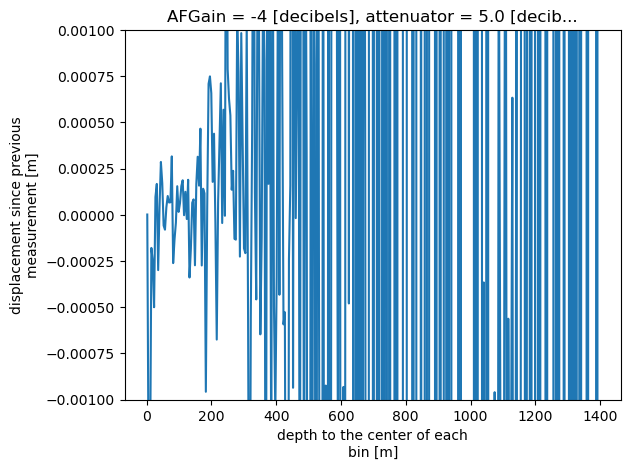

In [10]:
single.displacement.plot(ylim=[-0.001, 0.001], x = 'bin_depth')

### then using compute_displacements defined in utils.py

In [27]:
single2 = xa.utils.compute_displacement(from_zarr2.profile_stacked.isel(attenuator_setting_pair=0, time=0),from_zarr2.profile_stacked.isel(attenuator_setting_pair=0, time=1))

In [28]:
single2

<xarray.Dataset> Size: 285kB
Dimensions:            (shot_number: 2, profile_range: 6658, bin: 332)
Coordinates:
    AFGain             int64 8B dask.array<chunksize=(), meta=np.ndarray>
    attenuator         float64 8B dask.array<chunksize=(), meta=np.ndarray>
    burst_number       (shot_number) int64 16B 4 5
    filename           <U83 332B 'ldeo-glaciology/GL_apres_2022/A101/CardA/DI...
  * profile_range      (profile_range) float64 53kB 0.0 0.2103 ... 1.4e+03
    time               (shot_number) datetime64[ns] 16B 2022-05-29T15:06:19 2...
    bin_depth          (bin) float64 3kB 1.998 6.204 ... 1.39e+03 1.394e+03
Dimensions without coordinates: shot_number, bin
Data variables:
    profile_stacked    (shot_number, profile_range) complex128 213kB dask.array<chunksize=(1, 6658), meta=np.ndarray>
    coherence          (bin) complex128 5kB dask.array<chunksize=(332,), meta=np.ndarray>
    phase              (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    phase_uncertainty  (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    displacement       (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
    disp_uncertainty   (bin) float64 3kB dask.array<chunksize=(332,), meta=np.ndarray>
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

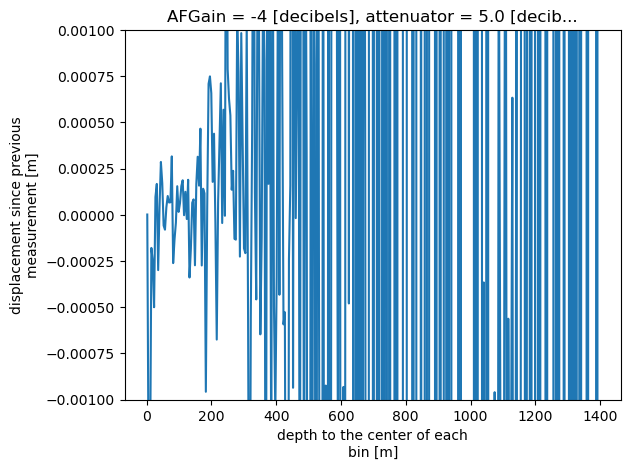

In [14]:
single2.displacement.plot(ylim=[-0.001, 0.001], x = 'bin_depth')

In [20]:
np.allclose(single.displacement.data, single2.displacement.data).compute()

np.True_

### Try it on polarmetric data
You dont just have to apply compute_displacement to profiles recorded at different times, you can apply it to profiles recorded at approximately the same time but with differnt antenna orientations.

Load some polarmetric data:

In [11]:
p = xa.load.generate_xarray(directory = "../../data/sample/polarmetric", polarmetric=True, attended=True)
p

<xarray.Dataset> Size: 205MB
Dimensions:          (orientation: 4, waypoint: 1, chirp_time: 40001,
                      chirp_num: 100, attenuator_setting_pair: 1,
                      profile_range: 11889)
Coordinates:
    time             (orientation, waypoint) datetime64[ns] 32B 2023-01-05T03...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (orientation, waypoint) <U56 896B '../../data/sample/pol...
    burst_number     (orientation, waypoint) int64 32B 0 0 0 0
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
  * orientation      (orientation) <U2 32B 'HH' 'HV' 'VH' 'VV'
  * waypoint         (waypoint) int64 8B 1
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (orientation, waypoint, chirp_time, chirp_num, attenuator_setting_pair) float64 128MB ...
    profile          (orientation, waypoint, profile_range, chirp_num, attenuator_setting_pair) complex128 76MB ...
    latitude         (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    longitude        (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    battery_voltage  (orientation, waypoint) float64 32B 0.0 0.0 0.0 0.0
    temperature_1    (orientation, waypoint) float64 32B 502.9 503.1 2.891 2.492
    temperature_2    (orientation, waypoint) float64 32B 501.6 503.6 511.8 4.93

In [12]:
p0 = p.profile.isel(orientation=0).mean(dim='chirp_num')
p3 = p.profile.isel(orientation=3).mean(dim='chirp_num')

In [34]:

profile1_unaligned = p0  
profile2_unaligned = p3

# if 
if 'time' not in profile1_unaligned.dims and 'time' in profile1_unaligned.coords:
    # data is taken in attended mode and we dont need to get the midpoint time and align
    print('attended mode')
    profiles = xr.concat([profile1_unaligned, profile2_unaligned], dim='shot_number')


else:

    # in the case when we selected the time step with .isel(time=N), where N is an integer, we dont have time as a dimension. THe following accounts for this scenario
    if 'time' not in profile1_unaligned.dims:
        profile1_unaligned = profile1_unaligned.expand_dims(dim="time")
    if 'time' not in profile2_unaligned.dims:
        profile2_unaligned = profile2_unaligned.expand_dims(dim="time")

    # record the time interval between measurements
    t1 = profile1_unaligned.time.data
    t2 = profile2_unaligned.time.data
    dt = t2-t1

    # change the name of the time coordinates so that they can be retained when the profiles are concatenated, then drop the original 'time' coordinates (the latter is achieved with drop_vars)
    profile1_unaligned = profile1_unaligned.assign_coords(profile_time=("time", profile1_unaligned.time.data)).drop_vars("time")
    profile2_unaligned = profile2_unaligned.assign_coords(profile_time=("time", profile2_unaligned.time.data)).drop_vars("time")

    # concatenate the two profiles
    profiles = xr.concat([profile1_unaligned, profile2_unaligned], dim='shot_number', coords=['profile_time', 'burst_number', 'filename'])

    # add the midpoint time 
    profiles = profiles.assign_coords(time=("time", t1+dt/2))
profiles

attended mode


<xarray.DataArray 'profile' (shot_number: 2, waypoint: 1, profile_range: 11889,
                             attenuator_setting_pair: 1)> Size: 380kB
array([[[[ 7.89051276e-03+0.00000000e+00j],
         [-1.31734439e-06+6.94924584e-03j],
         [-4.68549773e-03-2.47883300e-06j],
         ...,
         [ 3.46003844e-07+5.69271041e-06j],
         [-5.30304042e-06+4.04775467e-07j],
         [-4.25157973e-07-4.77999701e-06j]]],


       [[[ 7.67728476e-03+0.00000000e+00j],
         [-6.42831501e-07+6.76135291e-03j],
         [-4.55845996e-03-1.45193989e-06j],
         ...,
         [ 1.34090504e-07+5.03252862e-06j],
         [-4.94959333e-06-1.93892064e-07j],
         [ 3.53865073e-07-4.71013831e-06j]]]])
Coordinates:
    time           (shot_number, waypoint) datetime64[ns] 16B 2023-01-05T03:0...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
    filename       (shot_number, waypoint) <U56 448B '../../data/sample/polar...
    burst_number   (waypoint) int64 8B 0
    AFGain         (attenuator_setting_pair) int64 8B -4
    attenuator     (attenuator_setting_pair) float64 8B 22.0
    orientation    (shot_number) <U2 16B 'HH' 'VV'
  * waypoint       (waypoint) int64 8B 1
Dimensions without coordinates: shot_number, attenuator_setting_pair

In [31]:
profiles

<xarray.DataArray 'profile' (shot_number: 2, waypoint: 1, profile_range: 11889,
                             attenuator_setting_pair: 1)> Size: 380kB
array([[[[ 7.89051276e-03+0.00000000e+00j],
         [-1.31734439e-06+6.94924584e-03j],
         [-4.68549773e-03-2.47883300e-06j],
         ...,
         [ 3.46003844e-07+5.69271041e-06j],
         [-5.30304042e-06+4.04775467e-07j],
         [-4.25157973e-07-4.77999701e-06j]]],


       [[[ 7.67728476e-03+0.00000000e+00j],
         [-6.42831501e-07+6.76135291e-03j],
         [-4.55845996e-03-1.45193989e-06j],
         ...,
         [ 1.34090504e-07+5.03252862e-06j],
         [-4.94959333e-06-1.93892064e-07j],
         [ 3.53865073e-07-4.71013831e-06j]]]])
Coordinates:
    time           (shot_number, waypoint) datetime64[ns] 16B 2023-01-05T03:0...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
    filename       (shot_number, waypoint) <U56 448B '../../data/sample/polar...
    burst_number   (waypoint) int64 8B 0
    AFGain         (attenuator_setting_pair) int64 8B -4
    attenuator     (attenuator_setting_pair) float64 8B 22.0
    orientation    (shot_number) <U2 16B 'HH' 'VV'
  * waypoint       (waypoint) int64 8B 1
Dimensions without coordinates: shot_number, attenuator_setting_pair

In [14]:
xa.utils.compute_displacement(p0, p3)#.displacement.plot(y = 'bin_depth', yincrease=False)

<xarray.Dataset> Size: 509kB
Dimensions:            (shot_number: 2, waypoint: 1, profile_range: 11889,
                        attenuator_setting_pair: 1, bin: 594)
Coordinates:
    time               (shot_number, waypoint) datetime64[ns] 16B 2023-01-05T...
  * profile_range      (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03
    filename           (shot_number, waypoint) <U56 448B '../../data/sample/p...
    burst_number       (waypoint) int64 8B 0
    AFGain             (attenuator_setting_pair) int64 8B -4
    attenuator         (attenuator_setting_pair) float64 8B 22.0
    orientation        (shot_number) <U2 16B 'HH' 'VV'
  * waypoint           (waypoint) int64 8B 1
    bin_depth          (bin) float64 5kB 1.998 6.204 ... 2.492e+03 2.496e+03
Dimensions without coordinates: shot_number, attenuator_setting_pair, bin
Data variables:
    profile            (shot_number, waypoint, profile_range, attenuator_setting_pair) complex128 380kB ...
    coherence          (waypoint, bin, attenuator_setting_pair) complex128 10kB ...
    phase              (waypoint, bin, attenuator_setting_pair) float64 5kB -...
    phase_uncertainty  (waypoint, bin, attenuator_setting_pair) float64 5kB 0...
    displacement       (waypoint, bin, attenuator_setting_pair) float64 5kB -...
    disp_uncertainty   (waypoint, bin, attenuator_setting_pair) float64 5kB 9...
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the compute_displacement function in xapres usin...

## Summary
The following steps are used to compute displacements from ApRES data. They are described above and imlemented in xapres.utils:
- define two time series of ApRES profiles by taking every nth profile from a unattended ApRES dataset. 
- align the time series of profiles to the mid-point of each pair of measurements
- bin the profiles vertically
- compute the complex coherence between each bin in each pair of profiles
- use the phase of the coherence to compute the displacement 

The function displacement_timeseries is added to xarray.DataArrays when you load xapres and it implements all the steps above. 

The function xapres.utils.compute_displacements just does steps 2-5 (i.e. it doesnt define the time series for you), so you can just supply it with two time series (or just two profiles) and it computes the vertically binned displacements. 